# SGA-OX Demo

Skrypt przedstawia przykładową implementację algorytmu Simple Genetic Algorithm (SGA) z operatorem OX i jego zastosowanie do rozwiązywania problemu komiwojażera (ang. Travelling Salesman Problem, TSP). Popularne instancje problemu TSP można znaleźć w bibliotece TSPLib [1]. Skrypt skupia się na rozwiązywaniu instancji BERLIN52, w celu rozwiązywania innych instancji może okazać się konieczna zmiana ustawień parametrów algorytmu, a może też i operatorów ewolucyjnych.

Literatura:

[1] TSPLIB, http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from L2.sga import SGA
from L2.mutation import reverse_sequence_mutation, transposition_mutation
from L2.replacement import mu_plus_lambda_replacement
from L2.genetic_operator import ox

%matplotlib inline

## Input data

In [2]:
# BERLIN52

n = 52
print('Problem size: %d' % n)

coords = np.array([565.0, 575.0, 25.0, 185.0, 345.0, 750.0, 945.0, 685.0, 845.0, 655.0, 880.0, 660.0, 25.0, 230.0, 525.0, 1000.0, 580.0, 1175.0, 650.0, 1130.0, 1605.0, 620.0, 1220.0, 580.0, 1465.0, 200.0, 1530.0, 5.0, 845.0, 680.0, 725.0, 370.0, 145.0, 665.0, 415.0, 635.0, 510.0, 875.0, 560.0, 365.0, 300.0, 465.0, 520.0, 585.0, 480.0, 415.0, 835.0, 625.0, 975.0, 580.0, 1215.0, 245.0, 1320.0, 315.0, 1250.0, 400.0, 660.0, 180.0, 410.0, 250.0, 420.0, 555.0, 575.0, 665.0, 1150.0, 1160.0, 700.0, 580.0, 685.0, 595.0, 685.0, 610.0, 770.0, 610.0, 795.0, 645.0, 720.0, 635.0, 760.0, 650.0, 475.0, 960.0, 95.0, 260.0, 875.0, 920.0, 700.0, 500.0, 555.0, 815.0, 830.0, 485.0, 1170.0, 65.0, 830.0, 610.0, 605.0, 625.0, 595.0, 360.0, 1340.0, 725.0, 1740.0, 245.0])
coords = coords.reshape(n, 2)

A = np.empty((n, n))
for i in range(n):
    for j in range(n):
        A[i, j] = np.sqrt(((coords[i, :] - coords[j, :])**2).sum())
print('Distance matrix:\n', A)

p = [0, 48, 31, 44, 18, 40,  7,  8,  9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24,  3,  5, 14,  4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29,  1,  6, 41, 20, 16,  2, 17, 30, 21]
print('Optimal solution:\n', p)

Problem size: 52
Distance matrix:
 [[    0.           666.10809934   281.11385594 ...,   217.08293346
    789.38267019  1220.46097848]
 [  666.10809934     0.           649.32657423 ...,   596.25917184
   1421.55724471  1716.04924172]
 [  281.11385594   649.32657423     0.         ...,   463.24939288
    995.3140208   1483.59361012]
 ..., 
 [  217.08293346   596.25917184   463.24939288 ...,     0.           829.60834133
   1150.76061803]
 [  789.38267019  1421.55724471   995.3140208  ...,   829.60834133     0.
    624.81997407]
 [ 1220.46097848  1716.04924172  1483.59361012 ...,  1150.76061803
    624.81997407     0.        ]]
Optimal solution:
 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


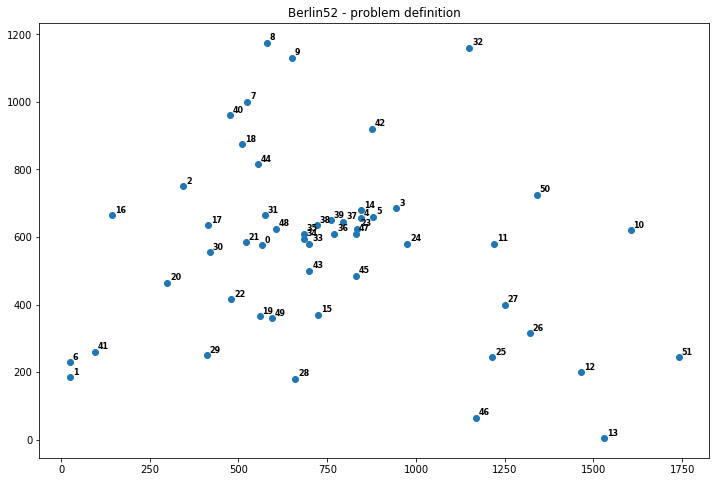

In [3]:
plt.figure(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

plt.title('Berlin52 - problem definition')

plt.show()

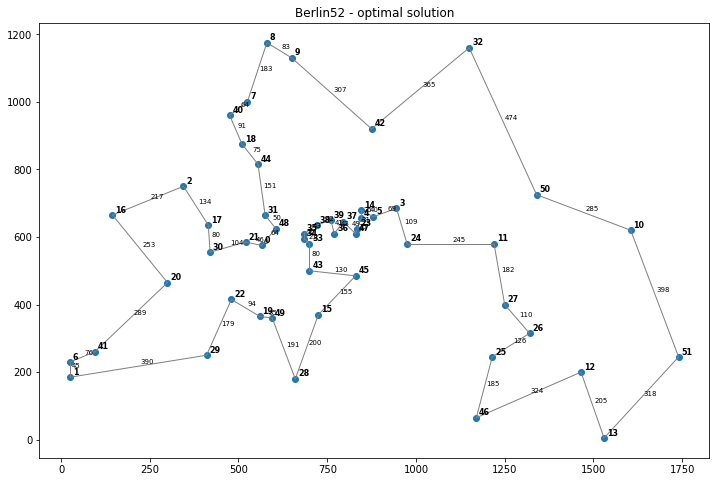

In [4]:
from matplotlib.lines import Line2D

route = p

plt.figure(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

ax.add_line(Line2D(
    [coords[0, 0], coords[route[0], 0]],
    [coords[0, 1], coords[route[0], 1]],
    linewidth=1, color='gray'))
plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
         (coords[0, 1] + coords[route[0], 1])/2 + 6,
         '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
for i in range(1, len(route)):
    ax.add_line(Line2D(
        [coords[route[i-1], 0], coords[route[i], 0]],
        [coords[route[i-1], 1], coords[route[i], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
             (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
             '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
ax.add_line(Line2D(
    [coords[route[-1], 0], coords[0, 0]],
    [coords[route[-1], 1], coords[0, 1]],
    linewidth=1, color='gray'))
plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
         (coords[route[-1], 1] + coords[0, 1])/2 + 6,
         '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})

plt.title('Berlin52 - optimal solution')

plt.show()

## Objective function

In [3]:
def tsp_objective_function(p):
    s = 0.0
    for i in range(n):
        s += A[p[i-1], p[i]]
    return s

In [4]:
print(tsp_objective_function(p), p)

7544.3659019 [0, 48, 31, 44, 18, 40, 7, 8, 9, 42, 32, 50, 10, 51, 13, 12, 46, 25, 26, 27, 11, 24, 3, 5, 14, 4, 23, 47, 37, 36, 39, 38, 35, 34, 33, 43, 45, 15, 28, 49, 19, 22, 29, 1, 6, 41, 20, 16, 2, 17, 30, 21]


## SGA-OX

In [9]:
sga_ox = SGA(tsp_objective_function, chromosome_length=n, 
             mutation=reverse_sequence_mutation,
             replacement=mu_plus_lambda_replacement,
             genetic_operator=ox)

In [31]:
sga_ox.evolve(population_size=500,
              number_of_iterations=250,
              crossover_probability=0.95,
              mutation_probability=0.25)

  0     0.05823469 24034.91428451 28460.02224157 29758.26666019 1031.39806575
  1     0.09500265 22973.61830316 27218.20270946 28412.73892366 960.01785034
  2     0.13017559 22973.61830316 26169.12652962 27270.86868710 855.49764482
  3     0.16538215 22507.12404185 25205.57962823 26198.74397060 788.23430713
  4     0.20037961 21211.99347942 24422.98039444 25359.80611965 725.06224141
  5     0.23557568 20346.94340240 23694.77185779 24602.21140513 718.26171122
  6     0.27181721 20346.94340240 23001.37775711 23837.97468380 686.98400643
  7     0.30838037 20134.28120823 22414.36844864 23249.91614978 705.33797046
  8     0.34348774 18936.80379289 21795.61630809 22625.32903678 658.71286869
  9     0.37892342 18936.80379289 21263.61898391 22035.66284497 561.54408661
 10     0.41355705 18551.41982048 20855.58050524 21476.88560140 514.74185073
 11     0.44844508 18150.38481987 20464.39564948 21111.65165981 522.44542356
 12     0.48471189 18024.28197008 20113.44360574 20702.48971100 512.9756816

114     4.04554868 8154.26876280 8154.26876280 8154.26876280   0.00000000
115     4.08050704 8154.26876280 8154.26876280 8154.26876280   0.00000000
116     4.11493039 8154.26876280 8154.26876280 8154.26876280   0.00000000
117     4.14978004 8154.26876280 8154.26876280 8154.26876280   0.00000000
118     4.18408680 8154.26876280 8154.26876280 8154.26876280   0.00000000
119     4.21809602 8154.26876280 8154.26876280 8154.26876280   0.00000000
120     4.25261664 8154.26876280 8154.26876280 8154.26876280   0.00000000
121     4.28703094 8154.26876280 8154.26876280 8154.26876280   0.00000000
122     4.32097578 8154.26876280 8154.26876280 8154.26876280   0.00000000
123     4.35562944 8154.26876280 8154.26876280 8154.26876280   0.00000000
124     4.38931823 8101.33109840 8154.16288747 8154.26876280   2.36507569
125     4.42361331 8101.33109840 8113.86041185 8154.26876280  22.45496387
126     4.45837116 8101.33109840 8101.33109840 8101.33109840   0.00000000
127     4.49386358 8101.33109840 8101.

228     8.01690078 7984.87828433 7984.87828433 7984.87828433   0.00000000
229     8.05705905 7984.87828433 7984.87828433 7984.87828433   0.00000000
230     8.09590387 7984.87828433 7984.87828433 7984.87828433   0.00000000
231     8.13309622 7984.87828433 7984.87828433 7984.87828433   0.00000000
232     8.17016625 7984.87828433 7984.87828433 7984.87828433   0.00000000
233     8.20883083 7984.87828433 7984.87828433 7984.87828433   0.00000000
234     8.24668670 7984.87828433 7984.87828433 7984.87828433   0.00000000
235     8.28405261 7984.87828433 7984.87828433 7984.87828433   0.00000000
236     8.31970072 7984.87828433 7984.87828433 7984.87828433   0.00000000
237     8.35692167 7984.87828433 7984.87828433 7984.87828433   0.00000000
238     8.39390874 7984.87828433 7984.87828433 7984.87828433   0.00000000
239     8.43128920 7984.87828433 7984.87828433 7984.87828433   0.00000000
240     8.46863842 7984.87828433 7984.87828433 7984.87828433   0.00000000
241     8.50550699 7984.87828433 7984.

(array([ 24034.91428451,  22973.61830316,  22973.61830316,  22507.12404185,
         21211.99347942,  20346.9434024 ,  20346.9434024 ,  20134.28120823,
         18936.80379289,  18936.80379289,  18551.41982048,  18150.38481987,
         18024.28197008,  17301.53059372,  17260.50958549,  16982.4455452 ,
         16721.44738695,  16347.70060516,  15928.32006232,  15575.13796673,
         15575.13796673,  14915.18525775,  14915.18525775,  14647.26527767,
         13985.26175705,  13985.26175705,  13766.5411312 ,  13304.48568964,
         13304.48568964,  13304.48568964,  13297.65143081,  12885.26947761,
         12885.26947761,  12532.9409177 ,  12525.3654771 ,  12437.09142353,
         12179.38783569,  12179.38783569,  11968.52151136,  11888.81136528,
         11449.03397548,  11189.14927601,  11189.14927601,  11189.14927601,
         10949.3600537 ,  10751.2439873 ,  10751.2439873 ,  10645.24629813,
         10525.568894  ,  10380.07432256,  10380.07432256,  10124.7387439 ,
          99

In [32]:
sga_ox.evolve(population_size=500,
              number_of_iterations=250,
              crossover_probability=0.95,
              mutation_probability=0.25)

  0     0.05680680 23827.75787313 28325.32639761 29736.50023848 1148.60914899
  1     0.09158444 23585.55167201 27080.37256857 28332.59505358 1003.14028829
  2     0.12697792 21869.84351781 25979.13357769 27147.32883888 872.57204242
  3     0.16151834 21726.49105030 25156.29160125 26160.61184757 714.32823883
  4     0.19559598 20854.71895587 24501.97764949 25358.75691849 752.73296312
  5     0.23106170 20091.41513668 23768.23348577 24682.78296770 826.21364261
  6     0.26650906 20091.41513668 22933.29048073 23937.17560266 781.86122931
  7     0.30055881 20070.55473480 22239.08287434 23115.24099688 699.41291141
  8     0.33562517 19547.51797269 21645.43089068 22457.69833718 638.51603443
  9     0.37024760 18518.37534657 21059.24410581 21836.39552347 612.61486669
 10     0.40446281 18028.74828071 20600.69500892 21353.17924794 520.70243535
 11     0.43923903 17919.03783991 20206.89344158 20796.14505472 504.96967059
 12     0.47496557 17281.77892004 19822.79197490 20429.25723629 546.531479

114     4.03348780 8114.46166850 8125.41974554 8164.10364230  20.56090629
115     4.06946945 8114.46166850 8114.46166850 8114.46166850   0.00000000
116     4.10381079 8114.46166850 8114.46166850 8114.46166850   0.00000000
117     4.13815355 8114.46166850 8114.46166850 8114.46166850   0.00000000
118     4.17356944 8114.46166850 8114.46166850 8114.46166850   0.00000000
119     4.20753622 8114.46166850 8114.46166850 8114.46166850   0.00000000
120     4.24249601 8114.46166850 8114.46166850 8114.46166850   0.00000000
121     4.27715468 8114.46166850 8114.46166850 8114.46166850   0.00000000
122     4.31146049 8114.46166850 8114.46166850 8114.46166850   0.00000000
123     4.34598017 8114.46166850 8114.46166850 8114.46166850   0.00000000
124     4.38033819 8114.46166850 8114.46166850 8114.46166850   0.00000000
125     4.41518402 8114.46166850 8114.46166850 8114.46166850   0.00000000
126     4.44939828 8114.46166850 8114.46166850 8114.46166850   0.00000000
127     4.48364210 8114.46166850 8114.

228     8.00185251 8063.16715300 8063.16715300 8063.16715300   0.00000000
229     8.03995991 8063.16715300 8063.16715300 8063.16715300   0.00000000
230     8.07513762 8063.16715300 8063.16715300 8063.16715300   0.00000000
231     8.10982561 8063.16715300 8063.16715300 8063.16715300   0.00000000
232     8.14503503 8063.16715300 8063.16715300 8063.16715300   0.00000000
233     8.18074727 8063.16715300 8063.16715300 8063.16715300   0.00000000
234     8.21604443 8063.16715300 8063.16715300 8063.16715300   0.00000000
235     8.25114775 8063.16715300 8063.16715300 8063.16715300   0.00000000
236     8.28564954 8063.16715300 8063.16715300 8063.16715300   0.00000000
237     8.32083368 8063.16715300 8063.16715300 8063.16715300   0.00000000
238     8.35560846 8063.16715300 8063.16715300 8063.16715300   0.00000000
239     8.39053249 8063.16715300 8063.16715300 8063.16715300   0.00000000
240     8.42576361 8063.16715300 8063.16715300 8063.16715300   0.00000000
241     8.46084261 8063.16715300 8063.

(array([ 23827.75787313,  23585.55167201,  21869.84351781,  21726.4910503 ,
         20854.71895587,  20091.41513668,  20091.41513668,  20070.5547348 ,
         19547.51797269,  18518.37534657,  18028.74828071,  17919.03783991,
         17281.77892004,  17281.77892004,  16339.13143615,  16339.13143615,
         16339.13143615,  15443.84478992,  15443.84478992,  15443.84478992,
         15121.23184537,  14963.03557898,  14963.03557898,  14762.99557447,
         14174.92820371,  14105.23504985,  14105.23504985,  13890.33132226,
         13596.98649883,  13596.98649883,  13322.74267093,  13098.21395808,
         12922.61350735,  12922.61350735,  12479.21056025,  12178.54262079,
         12040.21368869,  12040.21368869,  12040.21368869,  11882.41827114,
         11877.32177035,  11701.02589704,  11701.02589704,  11619.79396905,
         11282.79708518,  11052.44012024,  10978.47544784,  10887.69053722,
         10887.69053722,  10763.10184665,  10733.3967434 ,  10532.33429062,
         104

In [33]:
sga_ox.evolve(population_size=500,
              number_of_iterations=250,
              crossover_probability=0.95,
              mutation_probability=0.25)

  0     0.05656838 25081.10908505 28393.21163634 29651.47782011 948.26073381
  1     0.09154868 24427.47531573 27329.84670841 28388.58532687 797.96027169
  2     0.12637973 23206.61525395 26444.85767865 27414.17007724 722.50702452
  3     0.16166973 21362.50845526 25697.38516473 26539.97394333 752.57590228
  4     0.19576979 21362.50845526 24894.75133020 25839.86341156 794.36322712
  5     0.23088980 19893.16396295 24076.97375113 25110.91001975 840.21988547
  6     0.26641917 19893.16396295 23275.36270724 24276.11390424 818.87228366
  7     0.30123949 18652.98837227 22478.38859207 23426.60843080 811.47142835
  8     0.33713269 18525.56500033 21726.91287102 22731.18878195 841.68318865
  9     0.37146521 18525.56500033 20866.98414031 21845.04056527 790.60004390
 10     0.40663457 17904.82277551 20212.65824814 21071.06120619 657.50801760
 11     0.44197726 17137.53111691 19626.83207971 20397.33551535 588.99994341
 12     0.47769880 16276.44314232 19110.63804531 19780.48179335 521.93446653

114     4.04543281 7790.66828300 7795.76178499 7795.77199241   0.22801646
115     4.08070445 7790.66828300 7792.00545487 7795.77199241   2.24421657
116     4.11546445 7790.66828300 7790.66828300 7790.66828300   0.00000000
117     4.14965510 7790.66828300 7790.66828300 7790.66828300   0.00000000
118     4.18473911 7754.29273879 7790.59553191 7790.66828300   1.62513621
119     4.21958208 7754.29273879 7763.31387375 7790.66828300  15.70884521
120     4.25485229 7754.29273879 7754.29273879 7754.29273879   0.00000000
121     4.28986692 7726.37047100 7754.23689425 7754.29273879   1.24747243
122     4.32480168 7726.37047100 7733.49742316 7754.29273879  12.15896113
123     4.35963559 7726.37047100 7726.37047100 7726.37047100   0.00000000
124     4.39509463 7715.45918026 7726.34864842 7726.37047100   0.48747954
125     4.43108797 7715.45918026 7718.77621265 7726.37047100   5.01900398
126     4.46483660 7715.45918026 7715.45918026 7715.45918026   0.00000000
127     4.49943471 7715.45918026 7715.

227     7.74990535 7696.13620710 7696.13620710 7696.13620710   0.00000000
228     7.78051543 7696.13620710 7696.13620710 7696.13620710   0.00000000
229     7.81322575 7696.13620710 7696.13620710 7696.13620710   0.00000000
230     7.84453106 7696.13620710 7696.13620710 7696.13620710   0.00000000
231     7.87515354 7696.13620710 7696.13620710 7696.13620710   0.00000000
232     7.90557289 7696.13620710 7696.13620710 7696.13620710   0.00000000
233     7.93690252 7696.13620710 7696.13620710 7696.13620710   0.00000000
234     7.96942544 7696.13620710 7696.13620710 7696.13620710   0.00000000
235     8.00225520 7696.13620710 7696.13620710 7696.13620710   0.00000000
236     8.03527021 7696.13620710 7696.13620710 7696.13620710   0.00000000
237     8.06797194 7696.13620710 7696.13620710 7696.13620710   0.00000000
238     8.09962511 7696.13620710 7696.13620710 7696.13620710   0.00000000
239     8.13139081 7696.13620710 7696.13620710 7696.13620710   0.00000000
240     8.16343975 7696.13620710 7696.

(array([ 25081.10908505,  24427.47531573,  23206.61525395,  21362.50845526,
         21362.50845526,  19893.16396295,  19893.16396295,  18652.98837227,
         18525.56500033,  18525.56500033,  17904.82277551,  17137.53111691,
         16276.44314232,  15988.23628425,  15988.23628425,  15549.93643291,
         15341.43152998,  15093.06314296,  15056.28302825,  14512.33117429,
         14400.80837553,  14258.51742479,  14258.51742479,  14258.51742479,
         13844.57182161,  13650.74171292,  13650.74171292,  13650.74171292,
         13650.74171292,  13650.74171292,  13425.17004589,  12904.80241457,
         12860.77518989,  12860.77518989,  12812.89889546,  12812.89889546,
         12446.72858905,  12446.72858905,  12241.28807925,  12115.96933016,
         12115.96933016,  11909.09983675,  11909.09983675,  11805.94071804,
         11587.85332169,  11076.80914651,  11076.80914651,  11046.43696962,
         10899.83993417,  10510.51410638,  10510.51410638,  10510.51410638,
         103

In [34]:
best, best_chromosome = sga_ox.evolve(population_size=500,
                                      number_of_iterations=250,
                                      crossover_probability=0.95,
                                      mutation_probability=0.25)

  0     0.05563211 23704.90955833 28334.18511139 29681.03584981 1040.53637429
  1     0.09067106 23704.90955833 27138.41566929 28279.78032716 924.81469855
  2     0.12583041 23038.68737902 26129.48216953 27256.11193647 849.59283290
  3     0.16022682 22159.12638670 25327.82280677 26291.03470250 765.59842831
  4     0.19560552 21848.19428937 24653.95530749 25505.17509304 721.32909136
  5     0.23103595 20862.79485519 23958.86971676 24812.48418458 705.08075801
  6     0.26560664 20012.47595429 23318.43044807 24171.39343677 726.03450995
  7     0.30103445 19953.45490773 22699.02628217 23555.38758918 696.16406511
  8     0.33755040 18353.13210633 22096.54177099 22927.87148050 658.18999333
  9     0.37272024 18353.13210633 21517.40184885 22296.38384771 623.08564031
 10     0.40769768 18353.13210633 20990.26129022 21760.30190456 619.71978995
 11     0.44343448 18062.73125922 20480.99479551 21201.08223725 562.69521499
 12     0.47884536 17588.89412379 20020.22777775 20698.17245760 552.9781205

114     4.02724886 8537.65456320 8537.65456320 8537.65456320   0.00000000
115     4.06210446 8537.65456320 8537.65456320 8537.65456320   0.00000000
116     4.09688592 8537.65456320 8537.65456320 8537.65456320   0.00000000
117     4.13141108 8537.65456320 8537.65456320 8537.65456320   0.00000000
118     4.16662312 8537.65456320 8537.65456320 8537.65456320   0.00000000
119     4.20034218 8537.65456320 8537.65456320 8537.65456320   0.00000000
120     4.23456526 8537.65456320 8537.65456320 8537.65456320   0.00000000
121     4.26997042 8537.65456320 8537.65456320 8537.65456320   0.00000000
122     4.30430102 8537.65456320 8537.65456320 8537.65456320   0.00000000
123     4.33835292 8537.65456320 8537.65456320 8537.65456320   0.00000000
124     4.37281299 8537.65456320 8537.65456320 8537.65456320   0.00000000
125     4.40779400 8537.65456320 8537.65456320 8537.65456320   0.00000000
126     4.44224596 8537.65456320 8537.65456320 8537.65456320   0.00000000
127     4.47593307 8537.65456320 8537.

228     7.99112296 8537.65456320 8537.65456320 8537.65456320   0.00000000
229     8.02737284 8537.65456320 8537.65456320 8537.65456320   0.00000000
230     8.06307125 8537.65456320 8537.65456320 8537.65456320   0.00000000
231     8.09941602 8537.65456320 8537.65456320 8537.65456320   0.00000000
232     8.13511968 8537.65456320 8537.65456320 8537.65456320   0.00000000
233     8.16957188 8537.65456320 8537.65456320 8537.65456320   0.00000000
234     8.20697188 8537.65456320 8537.65456320 8537.65456320   0.00000000
235     8.24257374 8537.65456320 8537.65456320 8537.65456320   0.00000000
236     8.27735543 8537.65456320 8537.65456320 8537.65456320   0.00000000
237     8.31311512 8537.65456320 8537.65456320 8537.65456320   0.00000000
238     8.34893394 8537.65456320 8537.65456320 8537.65456320   0.00000000
239     8.38359356 8537.65456320 8537.65456320 8537.65456320   0.00000000
240     8.41959238 8537.65456320 8537.65456320 8537.65456320   0.00000000
241     8.45522761 8537.65456320 8537.

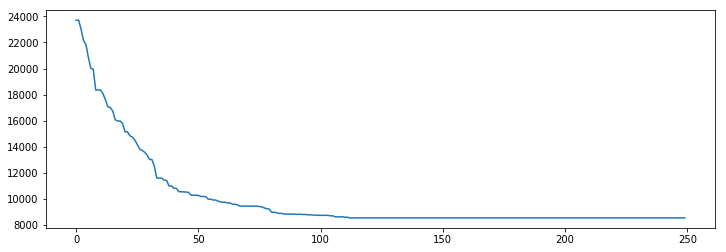

In [35]:
plt.figure(figsize=(12,4))
plt.plot(best)
plt.show()

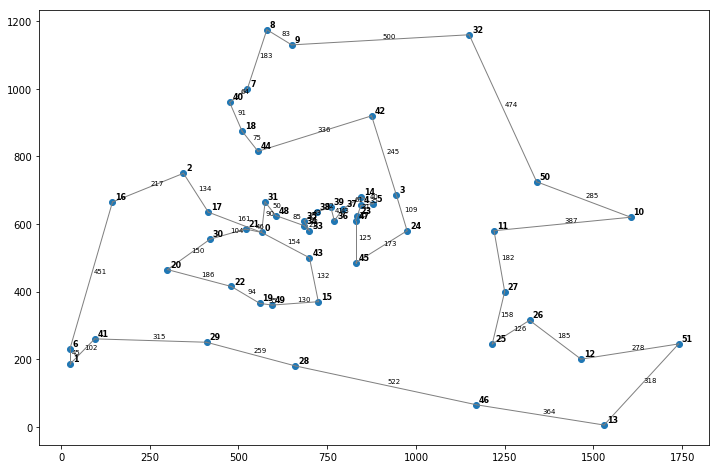

In [36]:
from matplotlib.lines import Line2D

route = best_chromosome
coords = coords.astype("int")

plt.figure(figsize=(12,8))
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(coords[:, 0], coords[:, 1], 'o')

for i in range(n):
    plt.text(coords[i, 0]+8, coords[i, 1]+8, str(i), fontdict={'weight':'bold', 'size':8})

ax.add_line(Line2D(
    [coords[0, 0], coords[route[0], 0]],
    [coords[0, 1], coords[route[0], 1]],
    linewidth=1, color='gray'))
plt.text((coords[0, 0] + coords[route[0], 0])/2 + 6,
         (coords[0, 1] + coords[route[0], 1])/2 + 6,
         '%d' % A[0, route[0]], fontdict={'weight':'normal', 'size':7})
for i in range(1, len(route)):
    ax.add_line(Line2D(
        [coords[route[i-1], 0], coords[route[i], 0]],
        [coords[route[i-1], 1], coords[route[i], 1]],
        linewidth=1, color='gray'))
    plt.text((coords[route[i-1], 0] + coords[route[i], 0])/2 + 6,
             (coords[route[i-1], 1] + coords[route[i], 1])/2 + 6,
             '%d' % A[route[i-1], route[i]], fontdict={'weight':'normal', 'size':7})
ax.add_line(Line2D(
    [coords[route[-1], 0], coords[0, 0]],
    [coords[route[-1], 1], coords[0, 1]],
    linewidth=1, color='gray'))
plt.text((coords[route[-1], 0] + coords[0, 0])/2 + 6,
         (coords[route[-1], 1] + coords[0, 1])/2 + 6,
         '%d' % A[route[-1], 0], fontdict={'weight':'normal', 'size':7})


plt.show()

In [37]:
sga_ox_transposition = SGA(tsp_objective_function, chromosome_length=n, 
                           mutation=transposition_mutation,
                           replacement=mu_plus_lambda_replacement,
                           genetic_operator=ox)

In [38]:
best_transposition, best_chromosome_transposition = sga_ox_transposition.evolve(
    population_size=500,
    number_of_iterations=250,
    crossover_probability=0.95,
    mutation_probability=0.25
)

  0     0.05277753 23685.46209857 28372.75084991 29601.47790730 1017.51165202
  1     0.08706641 23666.76965785 27168.00995809 28369.69634664 926.31930210
  2     0.12132931 23212.69212532 26132.32429199 27187.27811116 849.82157456
  3     0.15602016 22474.69067600 25320.86780817 26326.33068935 794.01919142
  4     0.18978238 21830.86156109 24611.91673043 25504.14583841 709.39704136
  5     0.22398376 20980.29602102 23960.72180335 24817.86246225 660.38639236
  6     0.25737214 20980.29602102 23396.78417006 24159.24614522 605.16656609
  7     0.29196835 19530.73266076 22915.03808120 23685.46209857 641.34090597
  8     0.32680631 18580.68042028 22387.10924799 23160.12841072 663.34094739
  9     0.36208439 18544.27250416 21822.04516800 22652.72445141 748.00894837
 10     0.39633155 17769.01834351 21135.81965012 22025.45515723 827.41163182
 11     0.43043947 17654.95882929 20425.06535352 21397.50102505 780.79525071
 12     0.46472120 17538.48562753 19793.50542621 20577.93169356 609.2749804

114     3.98499870 8813.61494547 8872.84172153 8873.07958007   3.75334443
115     4.01897097 8813.61494547 8827.05395289 8873.07958007  24.87043918
116     4.05360842 8813.61494547 8813.61494547 8813.61494547   0.00000000
117     4.08791447 8813.61494547 8813.61494547 8813.61494547   0.00000000
118     4.12139201 8809.44650719 8813.60660859 8813.61494547   0.18623172
119     4.15594959 8809.44650719 8810.60533304 8813.61494547   1.86751617
120     4.19061804 8809.44650719 8809.44650719 8809.44650719   0.00000000
121     4.22461653 8809.44650719 8809.44650719 8809.44650719   0.00000000
122     4.25803399 8809.44650719 8809.44650719 8809.44650719   0.00000000
123     4.29178858 8749.18354513 8809.32598127 8809.44650719   2.69234520
124     4.32609677 8749.18354513 8764.82960170 8809.44650719  26.36860255
125     4.35983038 8749.18354513 8749.18354513 8749.18354513   0.00000000
126     4.39479756 8739.93527789 8749.16504859 8749.18354513   0.41318128
127     4.42826939 8739.93527789 8741.

229     7.76629066 8650.36408403 8650.36408403 8650.36408403   0.00000000
230     7.79878879 8650.36408403 8650.36408403 8650.36408403   0.00000000
231     7.83032823 8650.36408403 8650.36408403 8650.36408403   0.00000000
232     7.86229849 8650.36408403 8650.36408403 8650.36408403   0.00000000
233     7.89334989 8650.36408403 8650.36408403 8650.36408403   0.00000000
234     7.92513180 8650.36408403 8650.36408403 8650.36408403   0.00000000
235     7.95598245 8650.36408403 8650.36408403 8650.36408403   0.00000000
236     7.98967075 8650.36408403 8650.36408403 8650.36408403   0.00000000
237     8.02121973 8650.36408403 8650.36408403 8650.36408403   0.00000000
238     8.05297184 8650.36408403 8650.36408403 8650.36408403   0.00000000
239     8.08399177 8650.36408403 8650.36408403 8650.36408403   0.00000000
240     8.11465621 8650.36408403 8650.36408403 8650.36408403   0.00000000
241     8.14574623 8650.36408403 8650.36408403 8650.36408403   0.00000000
242     8.17735529 8650.36408403 8650.

In [195]:
transposition_mutation(np.array([2, 1, 3, 7]))

array([3, 1, 2, 7])

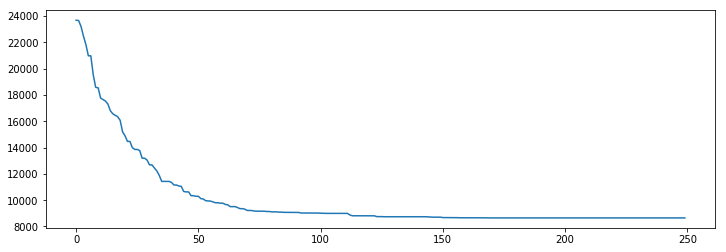

In [39]:
plt.figure(figsize=(12,4))
plt.plot(best_mut)
plt.show()

In [40]:
best_transposition, best_chromosome_transposition = sga_ox_transposition.evolve(
    population_size=500,
    number_of_iterations=250,
    crossover_probability=0.95,
    mutation_probability=0.25
)

  0     0.05650043 24222.08306605 28499.82726243 29841.37150021 991.82941450
  1     0.09109664 24222.08306605 27299.45826856 28384.91456224 896.16562715
  2     0.12597656 23304.96120588 26342.36054495 27444.51218672 837.71713145
  3     0.16014290 22397.11636636 25445.49267130 26415.36268990 731.97459732
  4     0.19386482 21884.44899658 24785.55059402 25608.95764852 688.84267714
  5     0.22766352 20922.14651715 24134.00360790 24967.53422681 694.47773732
  6     0.26177502 20725.18397902 23527.22388541 24399.21313810 712.05077391
  7     0.29628348 20548.89957276 22995.62117241 23804.37392112 659.24901468
  8     0.33091855 19641.82867543 22532.27429517 23304.96120588 596.28857110
  9     0.36507440 19641.82867543 22065.04283392 22811.46052584 586.10097192
 10     0.39901185 19641.82867543 21651.27270051 22338.02147829 535.29175061
 11     0.43227386 19428.20972433 21214.47166882 21869.56769725 500.75352030
 12     0.46718287 19230.05021977 20874.21724945 21459.77401817 459.89295325

108     3.89255476 10078.67551374 10078.67551374 10078.67551374   0.00000000
109     3.94267917 10078.67551374 10078.67551374 10078.67551374   0.00000000
110     3.97612500 10078.67551374 10078.67551374 10078.67551374   0.00000000
111     4.00962400 10063.45996859 10078.64508265 10078.67551374   0.67977906
112     4.04403138 10063.45996859 10067.44358312 10078.67551374   6.68612566
113     4.07796192 10063.45996859 10063.45996859 10063.45996859   0.00000000
114     4.12209463 10063.45996859 10063.45996859 10063.45996859   0.00000000
115     4.15674973 10063.45996859 10063.45996859 10063.45996859   0.00000000
116     4.19103408 10063.45996859 10063.45996859 10063.45996859   0.00000000
117     4.22560811 10063.45996859 10063.45996859 10063.45996859   0.00000000
118     4.25942683 10063.45996859 10063.45996859 10063.45996859   0.00000000
119     4.29372883 10063.45996859 10063.45996859 10063.45996859   0.00000000
120     4.32913208 10054.15916498 10063.44136698 10063.45996859   0.41552843

216     7.67628884 10054.15916498 10054.15916498 10054.15916498   0.00000000
217     7.71121645 10054.15916498 10054.15916498 10054.15916498   0.00000000
218     7.74574780 10054.15916498 10054.15916498 10054.15916498   0.00000000
219     7.78022099 10054.15916498 10054.15916498 10054.15916498   0.00000000
220     7.81470108 10054.15916498 10054.15916498 10054.15916498   0.00000000
221     7.84909892 10054.15916498 10054.15916498 10054.15916498   0.00000000
222     7.88309193 10054.15916498 10054.15916498 10054.15916498   0.00000000
223     7.91703939 10054.15916498 10054.15916498 10054.15916498   0.00000000
224     7.95137596 10054.15916498 10054.15916498 10054.15916498   0.00000000
225     7.98537755 10054.15916498 10054.15916498 10054.15916498   0.00000000
226     8.02028060 10054.15916498 10054.15916498 10054.15916498   0.00000000
227     8.05462003 10054.15916498 10054.15916498 10054.15916498   0.00000000
228     8.08919930 10054.15916498 10054.15916498 10054.15916498   0.00000000

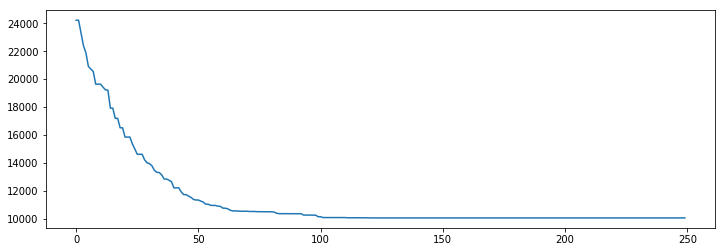

In [41]:
plt.figure(figsize=(12,4))
plt.plot(best_transposition)
plt.show()

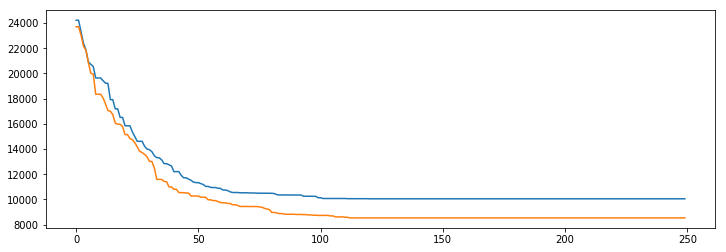

In [42]:
plt.figure(figsize=(12,4))
plt.plot(best_transposition)
plt.plot(best)
plt.show()